<a href="https://colab.research.google.com/github/alejogiley/Novartis-Hackaton-7/blob/master/Notebooks/Lee_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting affinities of antibiotic candidates to a DNA Gyrase

### Anaconda installation

In [0]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')

### Dependencies

In [3]:
import os

import numpy  as np      # scientific computing: arrays
import scipy  as sp      # scientific computing: statistics
import pandas as pd      # data analysis tools

# Tensor operations
import tensorflow as tf
import keras.backend as K

# Neural Network
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD

# Data processing & Cross-validation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

# Stats
from scipy.stats import linregress, kendalltau, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(0)

Using TensorFlow backend.


## <font color='green'>Data Processing</font>

In [0]:
# load features dataset
filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/AZ_Pyrrolamides_features_final.csv"
datasets = pd.read_csv(filepath)

# rename
datasets.rename(columns={'SAU Gyr IC50 (礛)':'pIC50'}, inplace=True)

pattern = "[<]"
filters = datasets.pIC50.str.contains(pattern)
datasets["left_saturated"] = filters

pattern = "[>]"
filters = datasets.pIC50.str.contains(pattern)
datasets["right_saturated"] = filters

# Reorder dataframe
cols = datasets.columns.tolist()
cols = cols[:2] + cols[-2:] + cols[2:-2]
datasets = datasets[cols]

datasets['pIC50'] = datasets['pIC50'].str.replace(r'[><]', '')
datasets['pIC50'] = datasets['pIC50'].apply(lambda x: np.log(float(x)))

# drop Ipc
datasets = datasets.drop(['Ipc'], axis=1)
cols.remove('Ipc')

Get the left censored and right censored sorted out.

In [0]:
# input and output
y = datasets['pIC50'].copy()
y = y.astype('float64').to_numpy()

x = datasets.iloc[:,4:].copy()
x = x.astype('float64').to_numpy()

# qualifiers classification
s1 = datasets['left_saturated' ].apply(lambda x: x*1).copy()
s2 = datasets['right_saturated'].apply(lambda x: x*1).copy()

s1 = s1.to_numpy()
s2 = s2.to_numpy()

s0 = s1 + s2

# > greater
rcutoff = s2 * datasets['pIC50'].copy().astype('float64')
rcutoff = rcutoff.to_numpy()

# < lower
lcutoff = s1 * datasets['pIC50'].copy().astype('float64')
lcutoff = lcutoff.to_numpy()

Check features.

In [0]:
corr = datasets.corr()
corr.loc[(corr['pIC50'] >= 0.4) | (corr['pIC50'] <= -0.4)]['pIC50'][1:]

qed                        0.491180
MolWt                     -0.526664
BertzCT                   -0.503721
PEOE_VSA1                 -0.450455
PEOE_VSA3                 -0.465307
SMR_VSA1                  -0.427446
SlogP_VSA2                -0.509821
TPSA                      -0.533955
EState_VSA2               -0.467875
VSA_EState9               -0.454508
NOCount                   -0.529112
NumAromaticHeterocycles   -0.400436
NumHAcceptors             -0.487935
NumHeteroatoms            -0.593323
NumRotatableBonds         -0.463759
fr_Ar_COO                 -0.486644
f_111                     -0.478565
f_186                     -0.459100
f_456                     -0.492155
f_667                      0.419061
f_807                     -0.456968
f_1242                    -0.411416
f_1403                    -0.471330
f_1601                    -0.400506
f_1634                     0.420678
f_2147                    -0.470485
f_2238                    -0.471330
f_2287                    -0

Split the machine-learning-ready dataset into __training__, __test__ and __validation__ subsets.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

## <font color='green'>Neural Network</font>

A simple Fully Connected Neural Network

### <font color='blue'>LOSS FUNCTION (with censored data)</font>

In [0]:
def custom_loss(y_true, y_pred):
    # get deltas
    z = y_pred - y_true
    r = y_pred - rcutoff
    l = y_pred - lcutoff
    # qualifiers adjusted Loss function
    #return K.mean((1-s0)*K.square(z), axis=-1)
    return K.mean((1-s0)*K.square(z) + s2*K.relu(-r) + s1*K.relu(l), axis=-1)

### Fully Connected Net

In [0]:
#The performance of common machine-learning algorithms can be very sensitive 
#to preprocessing of the data, neural networks mostly. Here we will normalize 
#the features and log(IC50) to have zero-mean and unit-standard-deviation 
#BatchNormalization

# Function to create model

def create_model(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=50, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    # hidden layer
    model.add(Dense(units=50))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    # hidden layer
    model.add(Dense(units=25))
    model.add(Activation("relu"))
    # output layer
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss=custom_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

### Run Lola, Run

Parameters are not optimized! No Grid search.

In [0]:
%%capture

# input dimensions
input_dim = x.shape[1]

# fix random seed
seed = 84
np.random.seed(seed)

# Clearing the NN
network = None 
network = create_model(input_dim) 

# Train neural network
history = network.fit(x_train,                          # Features
                      y_train,                          # Target
                      epochs=600,                       # Number of epochs
                      verbose=0,                        # No output
                      batch_size=50,                    # Number of observations per batch
                      validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [0]:
network.save("/content/network.h5")
print("Saved model to disk")

Saved model to disk


### <font color='red'>Load model</font>


In [0]:
network = create_model(x.shape[1])
network.load_weights('/content/network.h5')

### Evaluation

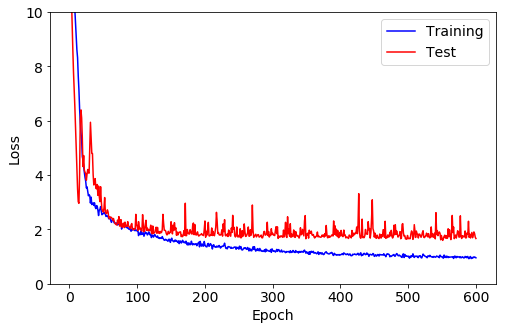

In [0]:
plt.rcParams["figure.figsize"] = (8,5)    # plot size

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b-')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training', 'Test'], fontsize=14)
plt.ylim([0,10])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [0]:
def plot_eval(model):
    
    plt.rcParams["figure.figsize"] = (18,6)
    fig, ax = plt.subplots()
    
    c = 'blue'                                   # train -- blue
    ax.scatter(y_train, model.predict(x_train),
               s=65, c=c, zorder=10, edgecolors='k')
    c = 'red'                                    # tests -- red
    ax.scatter(y_test,  model.predict(x_test),
               s=65, c=c, cmap=plt.cm.coolwarm, 
               zorder=10, edgecolors='k')
    
    ax.set_xlabel("pIC50 experimental", fontsize=16)
    ax.set_ylabel("pIC50 prediction",   fontsize=16)
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    # integer limits
    ilims = [int(x+0.5) for x in lims]
    ax.set_xticks(np.arange(*ilims,2))
    ax.set_yticks(np.arange(*ilims,2))
    
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.show()

### Plot prediction vs experiment

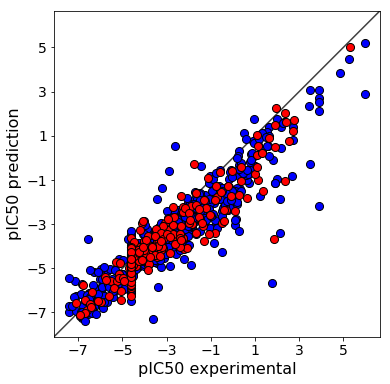

In [18]:
plot_eval(network)

### Statistics

In [0]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, network.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, network.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, network.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.7999762683085087
MAE         : 0.868749910881895
Kendall Tau : 0.6514616141034179


### Cross-validation

In [0]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    network = None
    network = create_model(x_test.shape[1]) 
    network.fit(x_train, y_train, epochs=600, verbose=0, batch_size=50)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, network.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, network.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, network.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.8108364676752725
MAE         : 0.9990610218902694
Kendall Tau : 0.6529958908599985
#------------------------#
R2          : 0.8053250035421872
MAE         : 0.991807894176793
Kendall Tau : 0.6595200704412476
#------------------------#
R2          : 0.800934404412126
MAE         : 1.2009194353390218
Kendall Tau : 0.6449666168461218
#------------------------#
R2          : 0.8463680078672
MAE         : 0.9060424442737987
Kendall Tau : 0.7021410245371132


## <font color='green'>Linear Model</font>

A strightforward linear regression model.

### Single Layer Net

In [0]:
# Function to create model
def create_linear(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=1, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(BatchNormalization())
    model.add(Activation("linear"))
    
    model.compile(loss=custom_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

### Rum, Rum

In [0]:
input_dim = x.shape[1]

# Clearing the LM
shallow = None 
shallow = create_linear(input_dim)                      # model

# Train shallow model
history = shallow.fit(x_train,                          # Features
                      y_train,                          # Target
                      epochs=600,                       # Number of epochs
                      verbose=0,                        # No output
                      validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [0]:
shallow.save("/content/shallow.h5")
print("Saved model to disk")

### <font color='red'>Load model</font>

In [0]:
shallow = None
shallow = create_linear(x.shape[1])
shallow.load_weights('/content/shallow.h5')

### Plot prediction vs experiment

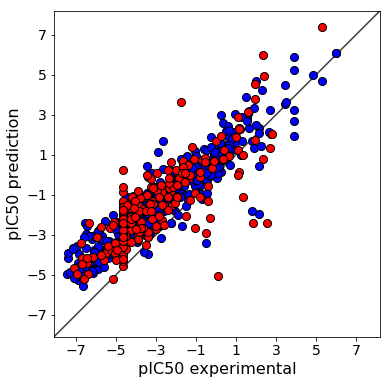

In [29]:
plot_eval(shallow)

### Statistics

In [30]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, shallow.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, shallow.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.8027562996295718
MAE         : 1.8147661990832769
Kendall Tau : 0.6196660293706511


### Cross-validation

In [31]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    shallow = None 
    shallow = create_model(x_test.shape[1])
    shallow.fit(x_train, y_train, epochs=600, verbose=0)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, shallow.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, shallow.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.7578133723680729
MAE         : 1.5432740480912581
Kendall Tau : 0.6126823627981923
#------------------------#
R2          : 0.8012894113111394
MAE         : 0.9318817067963144
Kendall Tau : 0.6463275969161622
#------------------------#
R2          : 0.7854288958767767
MAE         : 1.067217390106719
Kendall Tau : 0.6258605970704935
#------------------------#
R2          : 0.8414120963080912
MAE         : 0.9089222575359258
Kendall Tau : 0.6688290413137836


## <font color='green'>Control NN</font>

Repeat the previous methods but ignore censored data

### <font color='blue'>LOSS FUNCTION (without censored data)</font>

In [0]:
def normal_loss(y_true, y_pred):
    # get deltas
    z = y_pred - y_true
    r = y_pred - rcutoff
    l = y_pred - lcutoff
    # Loss function
    return K.mean((1-s0)*K.square(z), axis=-1)

### Fully Connected Net

In [0]:
#The performance of common machine-learning algorithms can be very sensitive 
#to preprocessing of the data, neural networks mostly. Here we will normalize 
#the features and log(IC50) to have zero-mean and unit-standard-deviation 
#BatchNormalization

# Function to create model

def create_model(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=50, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    # hidden layer
    model.add(Dense(units=50))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    # hidden layer
    model.add(Dense(units=25))
    model.add(Activation("relu"))
    # output layer
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss=normal_loss,                     # Normal loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

### Corre Lolita

In [0]:
%%capture

# input dimensions
input_dim = x.shape[1]

# fix random seed
seed = 84
np.random.seed(seed)

# Clearing the NN
network2 = None 
network2 = create_model(input_dim) 

# Train neural network
history = network2.fit(x_train,                          # Features
                       y_train,                          # Target
                       epochs=600,                       # Number of epochs
                       verbose=0,                        # No output
                       batch_size=50,                    # Number of observations per batch
                       validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [0]:
network2.save("/content/network2.h5")
print("Saved model to disk")

Saved model to disk


### <font color='red'>Load model</font>

In [0]:
network2 = None
network2 = create_model(x.shape[1])
network2.load_weights('/content/network2.h5')

### Evaluation

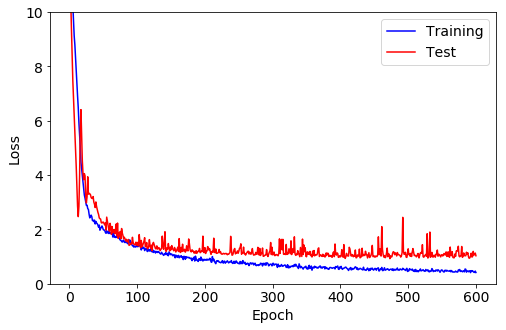

In [0]:
plt.rcParams["figure.figsize"] = (8,5)    # plot size

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b-')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training', 'Test'], fontsize=14)
plt.ylim([0,10])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Predictions versus Experiments

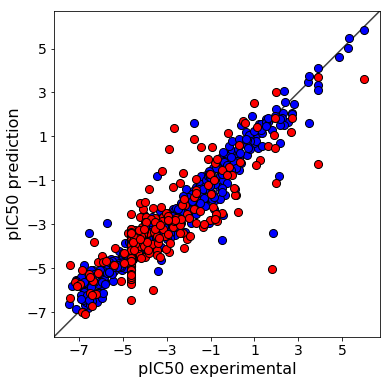

In [38]:
plot_eval(network2)

### Statistics

In [39]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, network2.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, network2.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, network2.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.848247001946622
MAE         : 0.8762908410090449
Kendall Tau : 0.6744976771143922


### Cross-validation

In [0]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    network2 = None
    network2 = create_model(x_test.shape[1]) 
    network2.fit(x_train, y_train, epochs=600, verbose=0, batch_size=50)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, network2.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, network2.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, network2.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.7729356592306579
MAE         : 0.9528109371741526
Kendall Tau : 0.6439062657720526
#------------------------#
R2          : 0.8237101153200256
MAE         : 0.9801287597213191
Kendall Tau : 0.6758897888990761
#------------------------#
R2          : 0.8229278529398483
MAE         : 0.9797821043860581
Kendall Tau : 0.6615113223764667
#------------------------#
R2          : 0.848247001946622
MAE         : 0.8762908410090449
Kendall Tau : 0.6744976771143922


## <font color='green'>Control LM</font>

### Single Layer Net



In [0]:
# Function to create model
def create_linear(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=1, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(BatchNormalization())
    model.add(Activation("linear"))
    
    model.compile(loss=normal_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

### Jogging

In [0]:
# Clearing the LM
shallow2 = None 
shallow2 = create_linear(input_dim)                      # model

# Train shallow model
history = shallow2.fit(x_train,                          # Features
                       y_train,                          # Target
                       epochs=600,                       # Number of epochs
                       verbose=0,                        # No output
                       validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [47]:
shallow2.save("/content/shallow2.h5")
print("Saved model to disk")

Saved model to disk


### <font color='red'>Load model</font>

In [0]:
shallow2 = None
shallow2 = create_linear(x.shape[1])
shallow2.load_weights('/content/shallow2.h5')

### Predictions versus Experiments

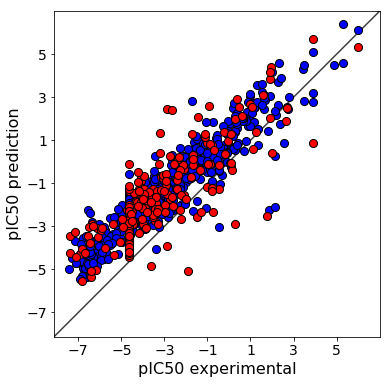

In [49]:
plot_eval(shallow2)

### Statistics

In [50]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow2.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, shallow2.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, shallow2.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.8193532308637571
MAE         : 1.859605963256285
Kendall Tau : 0.6435651212641577


### Cross-validation

In [0]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    shallow2 = None 
    shallow2 = create_model(x_test.shape[1])
    shallow2.fit(x_train, y_train, epochs=600, verbose=0)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow2.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, shallow2.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, shallow2.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.7964719553751531
MAE         : 1.0024179328929668
Kendall Tau : 0.6334289116630462
#------------------------#
R2          : 0.7953695851254657
MAE         : 1.0021198554606288
Kendall Tau : 0.6738176726385916
#------------------------#
R2          : 0.767119881700747
MAE         : 1.5684517377970664
Kendall Tau : 0.6206687438705945
#------------------------#
R2          : 0.84435420337604
MAE         : 0.9387357772866
Kendall Tau : 0.681565976075645


## <font color='green'>Validation</font>

External dataset from BindingDB for DNA Gyrase

### Data Processing

In [0]:
# load features dataset
filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/BindingDB_Gyrase_B_features.tsv"
validset = pd.read_csv(filepath)

# Rename columns
validset.rename(columns={'IC50':'pIC50'}, inplace=True)
validset.rename(columns={'Ligand SMILES':'Molecule SMILES'}, inplace=True)

# Modify dataset
validset['pIC50'] = validset['pIC50'].apply(lambda x: np.log(float(x)))
validset = validset.drop(['Ipc'], axis=1)

# New columns
pattern = "[<]"
filters = validset.Censorship.str.contains(pattern)
validset["left_saturated"] = filters

pattern = "[>]"
filters = validset.Censorship.str.contains(pattern)
validset["right_saturated"] = filters

# Reorder dataframe
cols = validset.columns.tolist()
cols = cols[:1] + cols[-4:] + cols[1:-4]
validset = validset[cols]

# Reorder dataframe
validset = validset[list(datasets.columns)]

# Remove SMILES
validset = validset[~validset['Molecule SMILES'].isin(datasets['Molecule SMILES'].values)]

In [0]:
# input and output
y = validset['pIC50'].copy()
y = y.astype('float64').to_numpy()

x = validset.iloc[:,4:].copy()
x = x.astype('float64').to_numpy()

### Plot pIC50 predictions

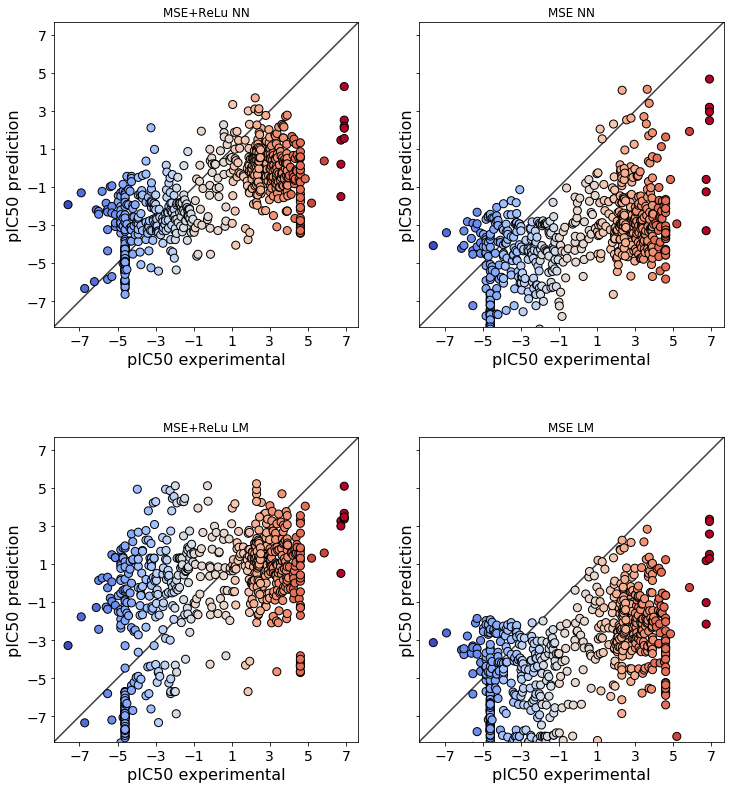

In [0]:
plt.rcParams["figure.figsize"] = (12,14)
fig, axes = plt.subplots(2, 2, sharey=True)

#-------------------------------------------------------------- PLOT 1
ax = axes[0,0]

c = y.astype(int)
ax.scatter(y, network.predict(x), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=16)
ax.set_ylabel("pIC50 prediction",   fontsize=16)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.title.set_text('MSE+ReLu NN')

#-------------------------------------------------------------- PLOT 2
ax = axes[0,1]

c = y.astype(int)
ax.scatter(y, network2.predict(x), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=16)
ax.set_ylabel("pIC50 prediction",   fontsize=16)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.title.set_text('MSE NN')

#-------------------------------------------------------------- PLOT 3
ax = axes[1,0]

c = y.astype(int)
ax.scatter(y, shallow.predict(x), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=16)
ax.set_ylabel("pIC50 prediction",   fontsize=16)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.title.set_text('MSE+ReLu LM')

#-------------------------------------------------------------- PLOT 4
ax = axes[1,1]

c = y.astype(int)
ax.scatter(y, shallow2.predict(x), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=16)
ax.set_ylabel("pIC50 prediction",   fontsize=16)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.title.set_text('MSE LM')

plt.show()

### Statistical Performance

In [0]:
labels = ['MSE+ReLu NN', 'MSE NN', 'MSE+ReLu LM', 'MSE LM']

i = 0
for name in [network, network2, shallow, shallow2]:
    
    slope, intercept, r_value, p_value, std_err = linregress(y, name.predict(x)[:,0])
    tau, p_value                                = kendalltau(y, name.predict(x)[:,0])
    rho, p_value                                = spearmanr(y, name.predict(x)[:,0])
    mae                                         = mean_absolute_error(y, name.predict(x)[:,0])
    mse                                         = mean_squared_error(y, name.predict(x)[:,0])
    
    print("##### METHOD: %s" % labels[i])
    print("Kendall Tau : %s" % tau)
    print("R2          : %s" % r_value)
    print("Spearman    : %s" % rho)
    print("MAE         : %s" % mae)
    print("RMSE        : %s" % np.sqrt(mse))
    print("")
    
    i+=1

##### METHOD: MSE+ReLu NN
Kendall Tau : 0.44357290026059476
R2          : 0.6826578503522251
Spearman    : 0.6430339331877768
MAE         : 2.2832820663189506
RMSE        : 2.886996163324604

##### METHOD: MSE NN
Kendall Tau : 0.37911001005945516
R2          : 0.5992860671350254
Spearman    : 0.541827518877421
MAE         : 4.011223426196923
RMSE        : 4.660112499780775

##### METHOD: MSE+ReLu LM
Kendall Tau : 0.30670711087024866
R2          : 0.501044105100726
Spearman    : 0.4444516102382497
MAE         : 2.73296448568427
RMSE        : 3.296377326685163

##### METHOD: MSE LM
Kendall Tau : 0.36743570115150576
R2          : 0.5758636203083733
Spearman    : 0.5435490603549381
MAE         : 3.892753247164956
RMSE        : 4.5864037546887815

